In [1]:
import argparse
import torch
import wandb

from my_dassl.utils import setup_logger, set_random_seed, collect_env_info
from my_dassl.config import get_cfg_default
from my_dassl.engine import build_trainer

import datasets.oxford_pets
import datasets.oxford_flowers
import datasets.fgvc_aircraft
import datasets.dtd
import datasets.eurosat
import datasets.stanford_cars
import datasets.food101
import datasets.sun397
import datasets.caltech101
import datasets.ucf101
import datasets.imagenet
import datasets.svhn
import datasets.resisc45
import datasets.clevr

import datasets.locmnist
import datasets.colour_biased_mnist

import trainers.coop
import trainers.cocoop
import trainers.zsclip
import trainers.ftclip
import trainers.vpwb
import trainers.vpour
# import trainers.blackvip
import trainers.blackvip_t2t
# import trainers.blackvip_jh
import trainers.reprogramming

import pdb

PATCH_NUM = 0
DATA = './datasets'
TRAINER = 'BLACKVIP'
SHOTS = 16
CFG = 'vit_b16'
ptb = 'vit-mae-base'

DATASET = 'eurosat'
ep = 5000

spsa_os = 1.0
alpha = 0.4
spsa_a = 0.01

b1 = float(0.9)
gamma = float(0.2)
spsa_c = float(0.005)
p_eps = float(0.4)

opt_type = 'spsa-gc'


/home/connor/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
def extend_cfg(cfg):
    """
    Add new config variables.

    E.g.
        from yacs.config import CfgNode as CN
        cfg.TRAINER.MY_MODEL = CN()
        cfg.TRAINER.MY_MODEL.PARAM_A = 1.
        cfg.TRAINER.MY_MODEL.PARAM_B = 0.5
        cfg.TRAINER.MY_MODEL.PARAM_C = False
    """
    from yacs.config import CfgNode as CN

    # ! DATASET CONFIG
    cfg.DATASET.SUBSAMPLE_CLASSES = "all"  # all, base or new

    cfg.DATASET.LOCMNIST = CN()
    cfg.DATASET.LOCMNIST.R_SIZE = 1
    cfg.DATASET.LOCMNIST.F_SIZE = 4

    cfg.DATASET.COLOUR_BIASED_MNIST = CN()
    cfg.DATASET.COLOUR_BIASED_MNIST.TRAIN_RHO = 0.8
    cfg.DATASET.COLOUR_BIASED_MNIST.TEST_RHO = 0.2
    cfg.DATASET.COLOUR_BIASED_MNIST.TRAIN_N_CONFUSING_LABELS = 9
    cfg.DATASET.COLOUR_BIASED_MNIST.TEST_N_CONFUSING_LABELS = 9
    cfg.DATASET.COLOUR_BIASED_MNIST.USE_TEST_AS_VAL = True
    cfg.DATASET.COLOUR_BIASED_MNIST.RANDOMIZE = True if args.randomize else False

    # ! Bahng et al. Visual Prompting (VP)
    cfg.TRAINER.VPWB = CN()
    cfg.TRAINER.VPWB.PREC = "amp"  # fp16, fp32, amp
    cfg.TRAINER.VPWB.METHOD = 'padding'  # 'padding', 'fixed_patch', 'random_patch'
    cfg.TRAINER.VPWB.IMAGE_SIZE = 224
    cfg.TRAINER.VPWB.PROMPT_SIZE = 30

    # ! Visual Prompting (VP) with SPSA
    cfg.TRAINER.VPOUR = CN()
    cfg.TRAINER.VPOUR.METHOD = 'padding'
    cfg.TRAINER.VPOUR.IMAGE_SIZE = 224
    cfg.TRAINER.VPOUR.PROMPT_SIZE = 30
    cfg.TRAINER.VPOUR.SPSA_PARAMS = [0.0, 0.001, 40.0, 0.6, 0.1]
    cfg.TRAINER.VPOUR.OPT_TYPE = "spsa-gc"
    cfg.TRAINER.VPOUR.MOMS = 0.9
    cfg.TRAINER.VPOUR.SP_AVG = 5

    # ! BlackVIP
    cfg.TRAINER.BLACKVIP = CN()
    cfg.TRAINER.BLACKVIP.METHOD = 'coordinator'
    cfg.TRAINER.BLACKVIP.PT_BACKBONE = ptb  # vit-base / vit-mae-base
    cfg.TRAINER.BLACKVIP.SRC_DIM = 1568  # 784 / 1568 / 3136 #? => only for pre-trained Enc
    cfg.TRAINER.BLACKVIP.E_OUT_DIM = 0  # 64 / 128 / 256 #? => only for scratch Enc
    cfg.TRAINER.BLACKVIP.SPSA_PARAMS = [1.0, 0.005, 0.01, 0.4, 0.2]
    cfg.TRAINER.BLACKVIP.OPT_TYPE = "spsa-gc"  # [spsa, spsa-gc, naive]
    cfg.TRAINER.BLACKVIP.MOMS = b1  # first moment scale.
    cfg.TRAINER.BLACKVIP.SP_AVG = 5  # grad estimates averaging steps
    cfg.TRAINER.BLACKVIP.P_EPS = p_eps  # prompt scale
    cfg.TRAINER.BLACKVIP.smoothing = False
    # ! Black-Box Adversarial Reprogramming (BAR)
    cfg.TRAINER.BAR = CN()
    cfg.TRAINER.BAR.METHOD = 'reprogramming'
    cfg.TRAINER.BAR.LRS = [0.01, 0.0001]
    cfg.TRAINER.BAR.FRAME_SIZE = 224
    cfg.TRAINER.BAR.SMOOTH = 0.01
    cfg.TRAINER.BAR.SIMGA = 1.0
    cfg.TRAINER.BAR.SP_AVG = 5
    cfg.TRAINER.BAR.FOCAL_G = 2.0

    # ! Full Fine Tune / Linear Probe
    cfg.TRAINER.FTCLIP = CN()
    cfg.TRAINER.FTCLIP.METHOD = 'ft'  # 'ft', 'lp'

    # ! CoOp, CoCoOp
    cfg.TRAINER.COOP = CN()
    cfg.TRAINER.COOP.N_CTX = 16  # number of context vectors
    cfg.TRAINER.COOP.CSC = False  # class-specific context
    cfg.TRAINER.COOP.CTX_INIT = ""  # initialization words
    cfg.TRAINER.COOP.PREC = "fp16"  # fp16, fp32, amp
    cfg.TRAINER.COOP.CLASS_TOKEN_POSITION = "end"  # 'middle' or 'end' or 'front'

    #
    cfg.OPTIM.MAX_EPOCH = 500
    cfg.DATASET.NUM_SHOTS = 16
    cfg.TRAIN.CHECKPOINT_FREQ = 500
    cfg.TRAINER.BLACKVIP.P_EPS_number = PATCH_NUM

    cfg.TRAINER.COCOOP = CN()
    cfg.TRAINER.COCOOP.N_CTX = 16  # number of context vectors
    cfg.TRAINER.COCOOP.CTX_INIT = ""  # initialization words
    cfg.TRAINER.COCOOP.PREC = "fp16"  # fp16, fp32, amp
def reset_cfg(cfg, args):
    if args.root:
        cfg.DATASET.ROOT = args.root

    if args.eval_only:
        cfg.eval_only = 1
    else:
        cfg.eval_only = 0

    if args.output_dir:
        cfg.OUTPUT_DIR = args.output_dir

    if args.resume:
        cfg.RESUME = args.resume

    if args.seed:
        cfg.SEED = args.seed

    if args.wb_method_name != 'no':
        cfg.WB_METHOD_NAME = args.wb_method_name

    if args.use_wandb:
        cfg.use_wandb = 1
    else:
        cfg.use_wandb = 0

    cfg.EVAL_MODE = 'best'

    if args.source_domains:
        cfg.DATASET.SOURCE_DOMAINS = args.source_domains

    if args.target_domains:
        cfg.DATASET.TARGET_DOMAINS = args.target_domains

    if args.transforms:
        cfg.INPUT.TRANSFORMS = args.transforms

    if args.trainer:
        cfg.TRAINER.NAME = args.trainer

    if args.backbone:
        cfg.MODEL.BACKBONE.NAME = args.backbone

    if args.head:
        cfg.MODEL.HEAD.NAME = args.head
    if args.patch_size:
        cfg.TRAINER.PATCH = args.patch_size

In [3]:
def setup_cfg(args):
    cfg = get_cfg_default()
    extend_cfg(cfg)

    # 1. From the dataset config file
    if args.dataset_config_file:
        cfg.merge_from_file(args.dataset_config_file)

    # 2. From the method config file
    if args.config_file:
        cfg.merge_from_file(args.config_file)

    # 3. From input arguments
    reset_cfg(cfg, args)

    # 4. From optional input arguments
    # print(args.opts)
    # cfg.merge_from_list(args.opts)

    cfg.freeze()
    return cfg
    
import argparse

# Manually creating a Namespace object to simulate command-line arguments
args = argparse.Namespace(
    root='./datasets',
    output_dir=f'output/eurosat/BLACKVIP_right_t2t_cls/vit-mae-base_vit_b16_t2t_s_inter/shot16_ep5000/spsa-gc_b10.9/a0.4_g0.2_sa0.01_sc0.005_eps0.4/seed1',
    # output_dir=f'output/eurosat/BLACKVIP/vit-mae-base_vit_b16/shot16_ep5000_orignal/spsa-gc_b10.9/a0.4_g0.2_sa0.01_sc0.005_eps0.4/seed1',
    # output_dir = f'output/eurosat/BLACKVIP/vit-mae-base_vit_b16/shot16_ep5000/spsa-gc_b10.9/a0.4_g0.2_sa0.01_sc0.005_eps0.4_jh/seed1',
    # output_dir = f'output/eurosat/BLACKVIP/vit-mae-base_vit_b16_nt/shot16_ep5000/spsa-gc_b10.9/a0.4_g0.2_sa0.01_sc0.005_eps0.4/seed2',
    # output_dir = f'output/eurosat/BLACKVIP_right_t2t/vit-mae-base_vit_b16_t2t/shot16_ep5000/spsa-gc_b10.9/a0.4_g0.2_sa0.01_sc0.005_eps0.4/seed1',
    # output_dir=f'output/colour_biased_mnist_easy/BLACKVIP/vit-mae-base_vit_b16_noaug/shot16_ep5000/spsa-gc_b10.9/a0.4_g0.1_sa0.01_sc0.01_eps1.0/seed1',
    resume='',
    seed=1,
    source_domains=None,  # Update this as needed
    target_domains=None,  # Update this as needed
    transforms=None,  # Update this as needed
    config_file='configs/trainers/BLACKVIP/vit_b16_t2t_s_inter.yaml',
    dataset_config_file='configs/datasets/eurosat.yaml',
    trainer='BLACKVIP',
    backbone='',  # Update this as needed
    head='',  # Update this as needed
    eval_only=False,
    model_dir='',  # Update this as needed
    load_epoch=None,  # Update this as needed
    no_train=False,
    use_wandb=False,
    wb_name='test',
    wb_method_name='no',
    randomize=1,
    patch_size = 16

    # opts=None  # Update this as needed, if you need to pass any additional command line arguments
)
def print_args(args, cfg):
    print("***************")
    print("** Arguments **")
    print("***************")
    optkeys = list(args.__dict__.keys())
    optkeys.sort()
    for key in optkeys:
        print("{}: {}".format(key, args.__dict__[key]))
    print("************")
    print("** Config **")
    print("************")
    print(cfg)


In [4]:
args.dataset_config_file = f'configs/datasets/eurosat.yaml'
cfg = setup_cfg(args)
if cfg.SEED >= 0:
    print("Setting fixed seed: {}".format(cfg.SEED))
    set_random_seed(cfg.SEED)
print_args(args, cfg)
print("Collecting env info ...")

# for strage test
AVAI_CHOICES = ["random_flip", "random_resized_crop", "normalize", "instance_norm", "random_crop", "random_translation", "center_crop",
    "cutout", "imagenet_policy", "cifar10_policy", "svhn_policy", "randaugment", "randaugment_fixmatch", "randaugment2", "gaussian_noise",
    "colorjitter", "randomgrayscale", "gaussian_blur",]
new_test_type = None #['randaugment_fixmatch'] # None # ['randaugment_fixmatch'] # None
# data suffle
cfg.merge_from_list(['DATALOADER.TEST.SAMPLER', 'RandomSampler']) # 'RandomSampler', 'SequentialSampler'
# for other data
cfg.merge_from_file(args.dataset_config_file)

if new_test_type is None:
    pass
elif new_test_type[0] == 'base':
    cfg.merge_from_list(['INPUT.TRANSFORMS', ('normalize', 'new_test_type')])
else:
    cfg.merge_from_list(['INPUT.TRANSFORMS', ('normalize', *new_test_type, 'new_test_type')])

# Creating the tuple with the desired format
trainer = build_trainer(cfg)
trainer.load_model(trainer.output_dir, epoch=5000)
dtype = trainer.model.dtype
data_loader =trainer.test_loader


Setting fixed seed: 1
***************
** Arguments **
***************
backbone: 
config_file: configs/trainers/BLACKVIP/vit_b16_t2t_s_inter.yaml
dataset_config_file: configs/datasets/eurosat.yaml
eval_only: False
head: 
load_epoch: None
model_dir: 
no_train: False
output_dir: output/eurosat/BLACKVIP_right_t2t_cls/vit-mae-base_vit_b16_t2t_s_inter/shot16_ep5000/spsa-gc_b10.9/a0.4_g0.2_sa0.01_sc0.005_eps0.4/seed1
patch_size: 16
randomize: 1
resume: 
root: ./datasets
seed: 1
source_domains: None
target_domains: None
trainer: BLACKVIP
transforms: None
use_wandb: False
wb_method_name: no
wb_name: test
************
** Config **
************
DATALOADER:
  K_TRANSFORMS: 1
  NUM_WORKERS: 8
  RETURN_IMG0: False
  TEST:
    BATCH_SIZE: 32
    SAMPLER: SequentialSampler
  TRAIN_U:
    BATCH_SIZE: 32
    N_DOMAIN: 0
    N_INS: 16
    SAME_AS_X: True
    SAMPLER: RandomSampler
  TRAIN_X:
    BATCH_SIZE: 128
    N_DOMAIN: 0
    N_INS: 16
    SAMPLER: RandomSampler
DATASET:
  ALL_AS_UNLABELED: False
  

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at facebook/vit-mae-base were not used when initializing PromptViTForImageClassification: ['decoder.decoder_layers.1.attention.attention.query.weight', 'decoder.decoder_layers.5.layernorm_after.weight', 'decoder.decoder_layers.2.attention.attention.value.bias', 'decoder.decoder_layers.0.layernorm_before.weight', 'decoder.decoder_layers.1.attention.attention.key.weight', 'decoder.decoder_layers.4.layernorm_before.bias', 'decoder.decoder_layers.3.attention.output.dense.weight', 'decoder.decoder_embed.weight', 'decoder.decoder_layers.0.attention.attention.query.weight', 'decoder.decoder_layers.7.output.dense.weight', 'decoder.decoder_layers.5.layernorm_before.weight', 'decoder.decoder_layers.7.attention.attention.value.weight', 'decoder.decoder_layers.2.attention.attention.key.weight', 'decoder.decoder_l


Loading evaluator: Classification
Load output/eurosat/BLACKVIP_right_t2t_cls/vit-mae-base_vit_b16_t2t_s_inter/shot16_ep5000/spsa-gc_b10.9/a0.4_g0.2_sa0.01_sc0.005_eps0.4/seed1/coordinator/model.pth.tar-5000 to coordinator (epoch=5000)


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 150/254 [02:41<01:52,  1.08s/it]


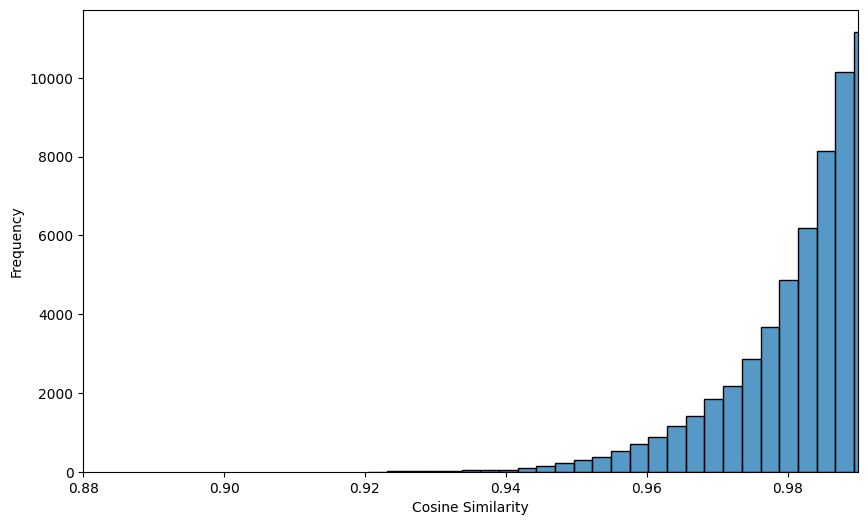

In [5]:
import numpy as np
def clip_clipping(x):
    #! -inf ~ inf -> CLIP's input RGB range
    if len(x.shape) == 3:
        out = torch.cat([torch.clip(x[0,:,:], min=-1.79226253, max=1.93033625).unsqueeze(0),
                     torch.clip(x[1,:,:], min=-1.75209713, max=2.07488384).unsqueeze(0),
                     torch.clip(x[2,:,:], min=-1.48021977, max=2.14589699).unsqueeze(0)], dim=0)
    else:
        out = torch.cat([torch.clip(x[:,0,:,:], min=-1.79226253, max=1.93033625).unsqueeze(1),
                        torch.clip(x[:,1,:,:], min=-1.75209713, max=2.07488384).unsqueeze(1),
                        torch.clip(x[:,2,:,:], min=-1.48021977, max=2.14589699).unsqueeze(1)], dim=1)
    return out
trainer.set_model_mode("eval")
trainer.evaluator.reset()
data_loader =trainer.test_loader
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import seaborn as sns
cnt = 0
for batch_idx, batch in enumerate(tqdm(data_loader)):
    input, label = trainer.parse_batch_test(batch)
    # if label[0] == 8:
    # if not torch.all(label == label[0]):
    #     continue
    cnt +=1
    prompt, z = trainer.model.coordinator(input.cuda().type(dtype))
    prompt = clip_clipping(prompt)
    # Flatten the images to shape [32, 150528]
    flattened_images = prompt.cpu().view(32, -1)
    flattened_images[1] = flattened_images[1]
    # Compute the cosine similarity
    cos_sim_matrix = torch.nn.functional.cosine_similarity(flattened_images[:, None], flattened_images, dim=-1)
    mask = np.triu_indices_from(cos_sim_matrix, k=1)
    if not batch_idx:
        cos_sim_values = cos_sim_matrix[mask]
    else:
        cos_sim_values = torch.cat((cos_sim_values, cos_sim_matrix[mask]), dim=0)
    if cnt>150:
        break
# Step 3 remains the same: Plot the distribution of cosine similarity values
plt.figure(figsize=(10, 6))
sns.histplot(cos_sim_values, bins=30, kde=0)
try: 
    plt.title(f'Distribution of Cosine Similarities_{new_test_type[0]} (Excluding Self-Comparison)')
except TypeError:
    pass
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.xlim(0.88, 0.99)
plt.show()

In [6]:
print( torch.mean(cos_sim_values),  torch.std(cos_sim_values))

tensor(0.9846) tensor(0.0103)


In [7]:
stop

NameError: name 'stop' is not defined

In [ ]:
from glob import glob
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from my_dassl.data.transforms import INTERPOLATION_MODES, build_transform
import torchvision.transforms as T
interp_mode = INTERPOLATION_MODES[cfg.INPUT.INTERPOLATION]
to_tensor = []
to_tensor += [T.Resize(cfg.INPUT.SIZE, interpolation=interp_mode)]
to_tensor += [T.ToTensor()]
if "normalize" in cfg.INPUT.TRANSFORMS:
    normalize = T.Normalize(
        mean=cfg.INPUT.PIXEL_MEAN, std=cfg.INPUT.PIXEL_STD
    )
    to_tensor += [normalize]
tensor_tr = T.Compose(to_tensor)
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define function to extract patches and calculate norms
def extract_patches_and_calculate_norms(tensor, patch_size=4, threshold=150, check=False):
    patches = tensor.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.contiguous().view(1, 3, -1, patch_size, patch_size)
    patches = patches.permute(2, 0, 1, 3, 4).reshape(-1, 3, patch_size, patch_size)
    norm_img = torch.norm(patches, p=2, dim=(1, 2, 3))
    indices_under_t = norm_img < threshold
    norms_under_t = norm_img[indices_under_t]
    if check:
        return norms_under_t, indices_under_t, norm_img
    return norms_under_t, indices_under_t

# Function to plot norms under threshold
def plot_norms_under_threshold(ax, norms, indices, title, patch_size=4):
    norms_image = torch.full((224 // patch_size, 224 // patch_size), float('nan'))
    norms_image[indices.view(224 // patch_size, 224 // patch_size)] = norms
    cax = ax.imshow(norms_image.numpy(), cmap='viridis')
    fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(title)


input_path = 'datasets/eurosat/2750/River/*.jpg'
# input_path = 'colour_biased_mnist/images_rho=0.2_ncl=9_rand=True/test/9/*.png'
eps = [1, 0.4]
patch_size = 4
threshold = 150
prompt_max = 150
path = f'check_prompt/{eps}_{patch_size}_{threshold}_{input_path[0:5]}_t2t_cls_check_detail_shared_{prompt_max}'
os.makedirs(path,exist_ok=True)
cnt = 0
with torch.no_grad():
    trainer.set_model_mode("eval")
    trainer.evaluator.reset()
    for i in glob(input_path):
        ori_img = Image.open(i).convert("RGB")
        img = tensor_tr(ori_img)
        img = img.unsqueeze(0)
        prompt, _ = trainer.model.coordinator(img.cuda().type(dtype))
        
        # Create image tensor (assuming the image size is [1, 3, 224, 224])
        

        input_tensor_2 = clip_clipping(img.cpu() + prompt.cpu() * eps[1])
        # Process both input and prompt tensors
        norms_img, img_indices = extract_patches_and_calculate_norms(clip_clipping(img), patch_size, threshold)
        norms_prompt, prompt_indices, prompt_norm = extract_patches_and_calculate_norms(clip_clipping(prompt.cpu()), patch_size, threshold, check=True)
        norms_input_2, input_2_indices = extract_patches_and_calculate_norms(input_tensor_2, patch_size, threshold)
        norms_input_max, input_max_indices = extract_patches_and_calculate_norms(clip_clipping(prompt.cpu()), patch_size, prompt_max)
        
        # Setup plot
        fig, axs = plt.subplots(2, 3, figsize=(12, 8))
        
        # Original image
        axs[0, 0].imshow(ori_img.resize((224, 224)))
        axs[0, 0].set_title('Original Image')
        
        # Plot norms under threshold for input and prompt
        plot_norms_under_threshold(axs[0, 1], norms_img, img_indices, f'Input Norms')
        plot_norms_under_threshold(axs[1, 0], norms_prompt, prompt_indices, f'Prompt Norms')
        plot_norms_under_threshold(axs[1, 2], norms_input_2, input_2_indices, f'Prompt Norms, eps : {eps[1]}')
        plot_norms_under_threshold(axs[1, 1], norms_input_max, input_max_indices, f'Prompt Norms, eps : {eps[1]} < {prompt_max}')
        # Distribution of all norms (Histogram)
        axs[0, 2].hist(norms_prompt.numpy(), bins=30, alpha=0.7, log=True)
        axs[0, 2].set_xlabel('Norm Value')
        axs[0, 2].set_ylabel('Frequency (Log Scale)')
        axs[0, 2].set_title('Distribution of All Norms')
                
        plt.tight_layout()
        #plt.savefig(f'{path}/{os.path.basename(i)}')
        plt.show()
        cnt +=1
        if cnt == 10:
            break
    